(4, 8)


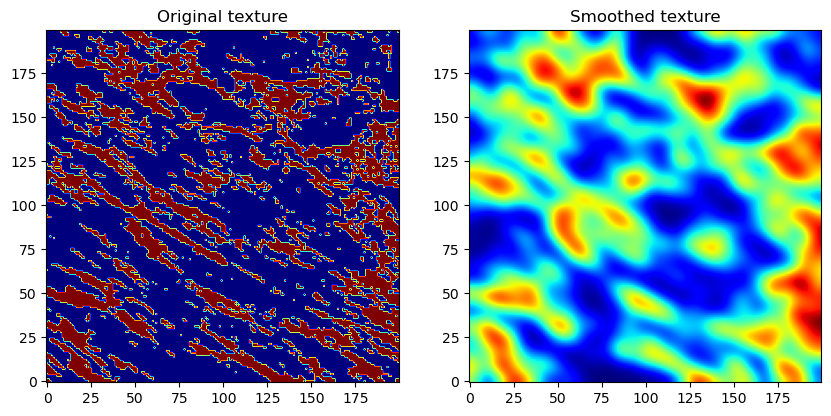

In [1]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

df = pd.read_csv(Path("/Users/arstanbek/Projects/fibrosis/BiTis/datasets") / "tissue_dataset.csv")

# Convert string representation of numpy arrays to numpy arrays:
df['Tissue Matrix'] = df['Tissue Matrix'].apply(
    lambda x: np.array(ast.literal_eval(x))
)
df['Tissue size'] = df['Tissue size'].apply(
    lambda x: ast.literal_eval(x)
)

# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'].between(0.3, 0.35)) &
                 (df['Elongation'] > 2.5)]

print(filtered_df.shape)
texture = filtered_df["Tissue Matrix"].iloc[0]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2).astype(np.float32)

texture_smoothed = gaussian_filter(texture, sigma=5)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(texture, cmap='jet', origin='lower')
axs[0].set_title('Original texture')
axs[1].imshow(texture_smoothed, cmap='jet', origin='lower')
axs[1].set_title('Smoothed texture')
plt.show()

100%|██████████| 40000/40000 [00:13<00:00, 2877.01it/s]


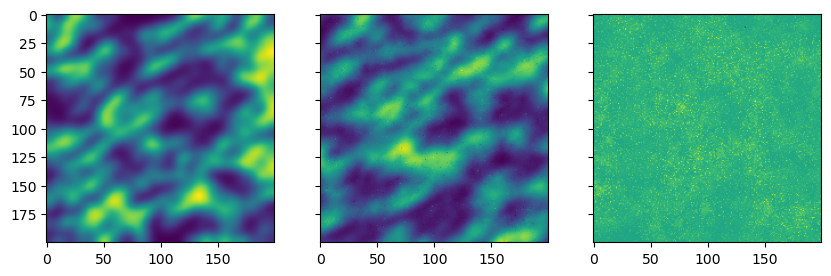

In [2]:
import bitis as bt
from scipy import ndimage

training_image = ndimage.gaussian_filter(texture.astype(np.float32), sigma=5)

max_known_pixels = 30
max_template_size = 40
min_template_size = 3
num_of_candidates = 2
min_known_pixels = 1
use_tf = False

simulation_tex = np.zeros_like(training_image)
simulation = bt.Simulation()
simulation.path_builder = bt.RandomSimulationPathBuilder(simulation_tex)
simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
simulation.template_matching = bt.ContinuousVariableMatching(training_image,
                                                             num_of_candidates,
                                                             min_known_pixels,
                                                             use_tf)
simulated_tex = simulation.run()
joint_image = simulated_tex.copy()

fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(training_image)
ax[1].imshow(joint_image)
ax[2].imshow(simulation._index_map)
plt.show()


In [3]:
import bitis as bt


training_image = texture

max_known_pixels = 30
max_template_size = 40
min_template_size = 3
num_of_candidates = 2
min_known_pixels = 1
use_tf = False

simulation_tex = np.zeros_like(training_image)
simulation = bt.Simulation()
simulation.path_builder = bt.RandomSimulationPathBuilder(simulation_tex)
simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
simulation.template_matching = bt.MultivariateVariableMatching(training_image,
                                                               joint_image,
                                                               num_of_candidates,
                                                               min_known_pixels,
                                                               use_tf)
simulated_tex = simulation.run()

fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(training_image)
ax[1].imshow(simulated_tex)
ax[2].imshow(simulation._index_map)
plt.show()

  0%|          | 5/40000 [00:00<00:07, 5107.53it/s]


ValueError: operands could not be broadcast together with shapes (161,161) (200,200) 